In [1]:
!pip install scikit-image

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd 
from PIL import Image 
from skimage.transform import resize
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split

In [3]:
# Load the images and some metadata  
img_dir = 'dummy_data/'
img_w, img_h, img_ch = 224, 224, 3
num_imgs = len(os.listdir(img_dir))
img_files = sorted(os.listdir(img_dir)) # sort them so they're in the same order as the labels 
print(img_files[:10]) # print the first few to see if they look right 

['001-2002-1_1.jpg', '001-2002-1_2.jpg', '001-2002-1_3.jpg', '001-2002-1_4.jpg', '002-2002-1_1.jpg', '002-2002-1_2.jpg', '002-2002-1_3.jpg', '002-2002-1_4.jpg', '003-2002-1_1.jpg', '003-2002-1_2.jpg']


In [4]:
# Load the labels 
labels_dir = 'labels.csv'
labels_df = pd.read_csv(labels_dir, usecols=['Individual Patch', 'Binary Outcome'])
labels_df = labels_df.sort_values(by=['Individual Patch']) # sort them so they're in the same order as the images 
labels_df.head() # print the first few to see if they look right 

,Individual Patch,Binary Outcome
0,001-2002-1_1,0
1,001-2002-1_2,0
2,001-2002-1_3,0
3,001-2002-1_4,0
10,002-2002-1_1,0


In [5]:
labels_df

,Individual Patch,Binary Outcome
0,001-2002-1_1,0
1,001-2002-1_2,0
2,001-2002-1_3,0
3,001-2002-1_4,0
10,002-2002-1_1,0
11,002-2002-1_2,0
12,002-2002-1_3,0
13,002-2002-1_4,1
4,003-2002-1_1,0
5,003-2002-1_2,0


In [6]:
# Iterate over all the images in the directory and place them in a numpy array 
# with their corresponding labels 
imgs = np.zeros((img_w, img_h, img_ch, num_imgs))
labels = np.zeros((num_imgs, 2))
for i, img_file in enumerate(img_files): 
    img = np.asarray(Image.open(img_dir + img_file))
    imgs[:,:,:,i] = resize(img, (img_w, img_h, img_ch)) 
    label = labels_df['Binary Outcome'].iloc[i] 
    if label == 0: # creates a one hot encoding for the label 
        labels[i,:] = [0, 1]
    else: 
        labels[i,:] = [1, 0]

[1. 0.]


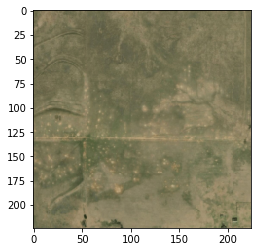

In [7]:
sample = 7
print(labels[sample,:])
plt.imshow(imgs[:,:,:,sample]) 

In [12]:
# Perform data augmentations to increase the size of the dataset 
flip_ud = np.zeros(imgs.shape)
flip_lr = np.zeros(imgs.shape) 
rot90 = np.zeros(imgs.shape)
rot180 = np.zeros(imgs.shape)
rot270 = np.zeros(imgs.shape)

for i in range(num_imgs):
    original_img = imgs[:,:,:,i] 
    flip_ud[:,:,:,i] = np.flip(original_img, 0) # flip the image up-down
    flip_lr[:,:,:,i] = np.flip(original_img, 1) # flip the image left-right
    rot90[:,:,:,i] = np.rot90(original_img, 1) # rotate the image 90 degrees 
    rot180[:,:,:,i] = np.rot90(original_img, 2) # rotate the image 180 degrees 
    rot270[:,:,:,i] = np.rot90(original_img, 3) # rotate the image 270 degrees 
    
# Put them all together in one matrix 
aug_imgs = np.concatenate((imgs, flip_ud, flip_lr, rot90, rot180, rot270), axis=3)
aug_labels = np.tile(labels, (6,1)) 

# Verify the shape of the resulting matrix 
print(aug_imgs.shape)
print(aug_labels.shape)

(224, 224, 3, 96)
(96, 2)


In [14]:
# Split into training, validation, and test sets 
# Note: We have to switch the order of the dimensions of the images so scikit can split it properly 

# Note: This will automatically shuffle the data before splitting it 
# Here we are splitting 70% for training and 20% for testing and 10% for validation 
# We have to use train_test_split twice in order to trick it into splitting off a validation set, too 
imgs_train, imgs_test, labels_train, labels_test = train_test_split(np.rollaxis(aug_imgs, 3), aug_labels, test_size=0.30) 
imgs_test, imgs_val, labels_test, labels_val = train_test_split(imgs_test, labels_test, test_size=0.33) 

In [15]:
# We can check that this worked by checking the size of everything 
print(imgs_train.shape, imgs_val.shape, imgs_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

(67, 224, 224, 3) (10, 224, 224, 3) (19, 224, 224, 3)
(67, 2) (10, 2) (19, 2)


In [16]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers

In [25]:
# since we will be testing many models, let's create a function to train, evaluate, and save statistics about each model 
# my_model: the keras model to train
# num_train_layers: the number of final layers to freeze in the network 
def train_model(my_model): 

    # compile the model
    print('compiling model',)
    my_model.compile(loss='mean_squared_error',
        optimizer=optimizers.Adam(),
        metrics=['acc'])
    print('done')
    
    # train the model
    print('training model',)
    history = my_model.fit(
        imgs_train,
        labels_train, 
        validation_data=(imgs_val,labels_val), 
        batch_size=8, 
        epochs=10 
    )
    print('done')
    
    # Save training statistics 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(my_model.name + '_accuracy.png') 
    

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(my_model.name + '_loss.png') 
    
    # Evaluate the model 

    # Save the model
    my_model.save(my_model.name + '.h5')

In [17]:
vgg16_model = VGG16(weights=None, input_shape=((img_w, img_h, img_ch)), classes=2)
vgg16_model.summary() # let's look at the layers inside this model 

Instructions for updating:
Colocations handled automatically by placer.


compiling model
done
training model
Train on 67 samples, validate on 10 samples
Epoch 1/10
67/67 [==============================] - 2s 25ms/sample - loss: 0.1791 - acc: 0.8209 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
67/67 [==============================] - 1s 14ms/sample - loss: 0.1791 - acc: 0.8209 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
67/67 [==============================] - 1s 14ms/sample - loss: 0.1791 - acc: 0.8209 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
67/67 [==============================] - 1s 14ms/sample - loss: 0.1791 - acc: 0.8209 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
67/67 [==============================] - 1s 14ms/sample - loss: 0.1791 - acc: 0.8209 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
67/67 [==============================] - 1s 14ms/sample - loss: 0.1791 - acc: 0.8209 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
67/67 [==============================] - 1s 14ms/sample - loss: 0.1791 - acc: 0.8209 - 

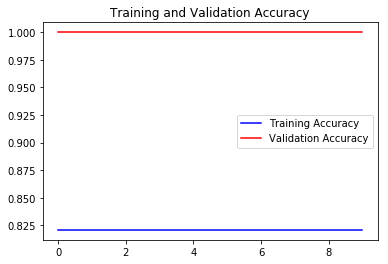

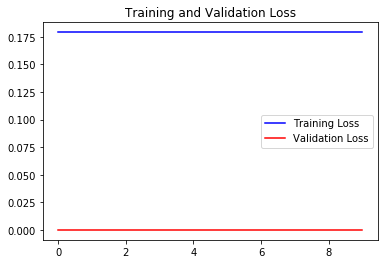

In [26]:
train_model(vgg16_model) 

In [ ]:
vgg16_model = VGG16(weights=None, input_shape=((img_w, img_h, img_ch)), classes=2)
train_model(vgg16_model) 